# Neural Network approach to solve imbalance data classification (Without HyperParameter tuning)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy
import json
import os
import pickle
import pandas as pd

import tensorflow as tf
import keras
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.models import load_model
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# things we need for Tensorflow
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

Using TensorFlow backend.


In [18]:
keras_model_path = "models/keras_model.h5"
keras_model_weight_file = "models/keras_model_weight.h5"

In [19]:
# read preprocessed data from pickle
with open('df_with_dummies.pkl', 'rb') as f:
    df_with_dummies = pickle.load(f)
df_with_dummies.head()

,age,start_bmi,activity_factor,hypothyroid,diabetes,pcos,physical,hypertension,high_blood_pressure,cholesterol,medical_conditions,devicebrand,paid,gender_female,gender_male,OS_android,OS_both,OS_ios
0,44.0,32.7,1.725,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1
1,63.0,33.7,1.200,0,0,0,0,0,0,0,0,4,0,1,0,1,0,0
3,107.0,34.9,1.200,0,0,0,0,0,0,0,0,4,0,0,1,1,0,0
4,98.0,37.8,1.375,1,0,0,0,0,0,0,1,1,0,1,0,1,0,0
5,85.0,28.6,1.550,0,0,0,0,0,0,0,0,4,0,0,1,1,0,0


In [20]:
# Split the data into features and target label
paid_raw = df_with_dummies['paid']
features_raw = df_with_dummies.drop('paid', axis = 1)

In [27]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
sm = SMOTEENN()
smote_features, smote_paid = sm.fit_sample(features_raw, paid_raw)
print('After SMOTE dataset shape {}'.format(Counter(smote_paid)))

After SMOTE dataset shape Counter({1: 79631, 0: 73853})


In [28]:
# Initialize a scaler, then apply it to the features
scaler = StandardScaler()
scaled_smote_features = scaler.fit_transform(smote_features)

In [29]:
def split_train_test(data_x, data_y):
    X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.30, random_state=40)
    return X_train, X_test, y_train, y_test

In [30]:
# Custom metrics for model validation
def custom_metrics(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

# Initializing the ANN model with 3 hidden layers and 1 output layers

I am going to use Relu as activation function in hidden layers as it handles vanishing/exploding gradient problems quites well and sigmoid in output layer as it is binary classification. Adam is used for optimization with binary_crossentropy loss. Metrics is logloss.

In [44]:
def keras_classifier(X_train, y_train, class_weights = None, val_split = 0):
    print(X_train.shape, y_train.shape)
    # Initialising the ANN
    classifier = Sequential()
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) # sgd is giving more loss
    # Adding the input layer and the first hidden layer
    classifier.add(Dense(units=128, kernel_initializer='normal', activation='relu', input_dim=X_train.shape[1], name = 'dense_1'))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(0.5))
    # Adding the second hidden layer
    classifier.add(Dense(units=128, kernel_initializer='normal', activation='relu', name = 'dense_2'))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(0.5))
    # Adding the third hidden layer
    classifier.add(Dense(units=64, kernel_initializer='normal', activation='relu', name = 'dense_3'))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(0.5))
    # Adding the output layer
    classifier.add(Dense(units=1, kernel_initializer='normal', activation='sigmoid', name='dense_4'))
    # Compiling the ANN
    classifier.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    # Fitting the ANN to the Training set
    history = classifier.fit(X_train, y_train, validation_split=val_split, class_weight = class_weight, batch_size=32, shuffle=True, epochs=50)
    # Visualizing model
    if val_split > 0.0:
        vis_model(history)
    classifier.save(keras_model_path)
    classifier.save_weights(keras_model_weight_file)
    return classifier

# Visualize the model

In [45]:
def vis_model(history):
    # print(history.history)
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Plot confusion matrix

In [46]:
def plot_confusion_matrix(y_test, predicted_labels):
    cm = confusion_matrix(y_test, predicted_labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

    # view with a heatmap
    sns.heatmap(cm, annot=True, cmap='Blues', square=True, fmt='.4f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix')
    plt.show()

# Get class weights

In [47]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(smote_paid), smote_paid)
print(class_weight)

[ 1.03911825  0.96372016]


# Start training and validating the NN model

(153484, 17) (153484,)
Train on 115113 samples, validate on 38371 samples
Epoch 1/50
115113/115113 [==============================] - 16s - loss: 0.5023 - acc: 0.7659 - val_loss: 0.6587 - val_acc: 0.5864
Epoch 2/50
115113/115113 [==============================] - 19s - loss: 0.4362 - acc: 0.8149 - val_loss: 0.6133 - val_acc: 0.6018
Epoch 3/50
115113/115113 [==============================] - 18s - loss: 0.4180 - acc: 0.8231 - val_loss: 0.6227 - val_acc: 0.6052
Epoch 4/50
115113/115113 [==============================] - 17s - loss: 0.4101 - acc: 0.8281 - val_loss: 0.5327 - val_acc: 0.6252
Epoch 5/50
115113/115113 [==============================] - 16s - loss: 0.4112 - acc: 0.8274 - val_loss: 0.6125 - val_acc: 0.6023
Epoch 6/50
115113/115113 [==============================] - 18s - loss: 0.4101 - acc: 0.8276 - val_loss: 0.5577 - val_acc: 0.6155
Epoch 7/50
115113/115113 [==============================] - 19s - loss: 0.4039 - acc: 0.8296 - val_loss: 0.6631 - val_acc: 0.6004
Epoch 8/50
11511

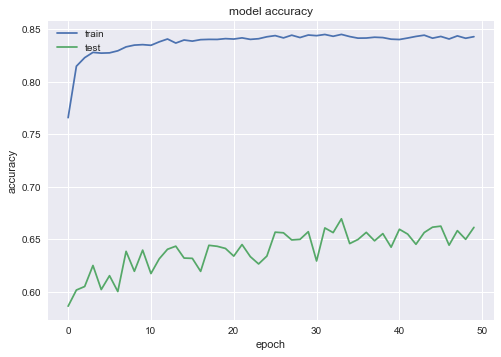

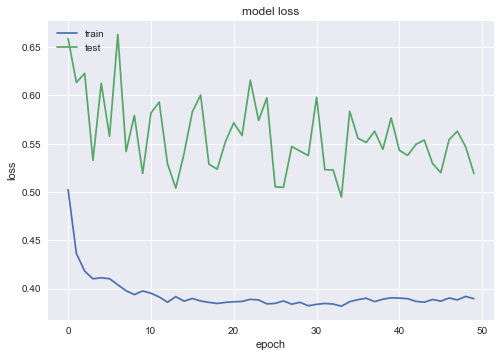

In [48]:
# for imbalance data
model = keras_classifier(scaled_smote_features, smote_paid, val_split = 0.25)

Running on high epoch can increase the validation accuracy, but the result is not promising here. ML models are working far better on oversampled data than NN models.

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2304      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
__________

In [37]:
X_train, X_test, y_train, y_test = split_train_test(scaled_smote_features, smote_paid)

# Assigning more weights to the less represented data
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
print("class_weieght: ", class_weight)

# for imbalance data
print("Training started... Please wait...")
model = keras_classifier(X_train, y_train, class_weight)
print("Done Training...")

class_weieght:  [ 1.03792797  0.96474624]
Training started... Please wait...
(107438, 17) (107438,)
Epoch 1/50
107438/107438 [==============================] - 14s - loss: 0.5360 - acc: 0.7135    
Epoch 2/50
107438/107438 [==============================] - 13s - loss: 0.4682 - acc: 0.7620    
Epoch 3/50
107438/107438 [==============================] - 13s - loss: 0.4578 - acc: 0.7688    
Epoch 4/50
107438/107438 [==============================] - 14s - loss: 0.4500 - acc: 0.7720    
Epoch 5/50
107438/107438 [==============================] - 13s - loss: 0.4447 - acc: 0.7763    
Epoch 6/50
107438/107438 [==============================] - 13s - loss: 0.4413 - acc: 0.7796    
Epoch 7/50
107438/107438 [==============================] - 14s - loss: 0.4342 - acc: 0.7817    
Epoch 8/50
107438/107438 [==============================] - 15s - loss: 0.4350 - acc: 0.7822    
Epoch 9/50
107438/107438 [==============================] - 16s - loss: 0.4328 - acc: 0.7850    
Epoch 10/50
107438/107438 [

acc: 83.75%


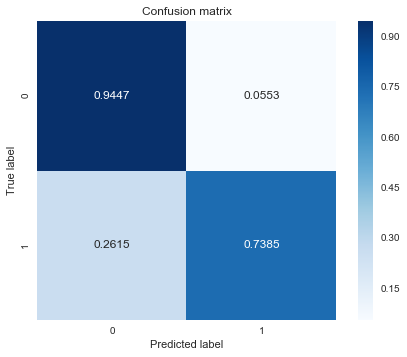

In [38]:
X_test = np.array(X_test)
predict_val = model.predict(X_test)
predict_val = [1 if each >= 0.5 else 0 for each in predict_val]
predict_df = pd.Series(predict_val)

scores = model.evaluate(X_test, y_test, verbose = 0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

plot_confusion_matrix(y_test, predict_df)

In [41]:
fpr, tpr, threshold = roc_curve(y_test, predict_df)
roc_auc = roc_auc_score(y_test, predict_df)

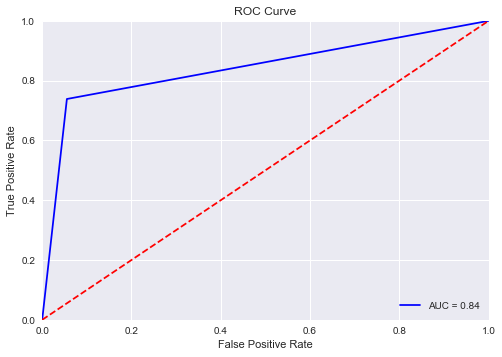

In [42]:
import matplotlib.pyplot as plt
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()